#**Section 2.2**

### Imports & Helper Function  
Loads core libraries (NumPy for array ops; PyTorch for model building; Matplotlib for plotting) and defines `random_batch()`, which returns a random mini‑batch of one‑hot encoded target words paired with their context labels.

---

### Data Preparation  
Defines hyperparameters, builds a vocabulary from example sentences, and generates skip‑gram pairs (target → context) for training.

---

### Training Loop  
Instantiates the Word2Vec model, loss function, and optimizer; then trains for 5,000 epochs using randomly sampled batches, printing loss every 1,000 epochs.

---

### Plot Learned Embeddings  
Extracts the trained embedding weights, projects each word into 2D, and visualizes them on a scatter plot with word annotations.

<ipython-input-1-ee94cf22a187>:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  inputs = torch.Tensor(inputs)            # [batch_size, voc_size]


Epoch: 1000, Loss = 2.063892
Epoch: 2000, Loss = 2.005985
Epoch: 3000, Loss = 1.358858
Epoch: 4000, Loss = 0.965480
Epoch: 5000, Loss = 2.098031


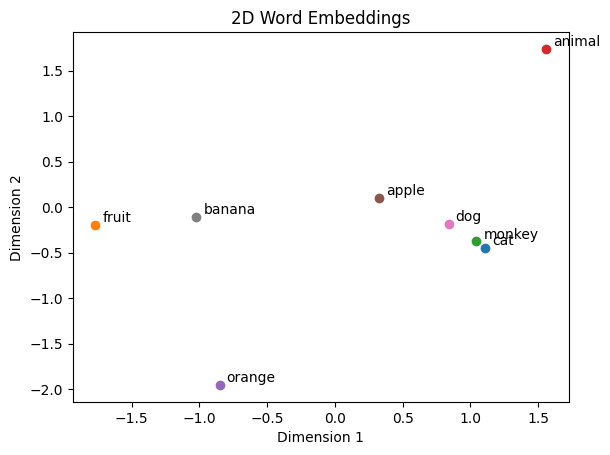

In [ ]:
# === Cell: Imports & Helper Function ===

# Basic libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    """
    Samples a random mini‑batch of skip‑gram pairs.
    Returns one‑hot encoded inputs and integer labels.
    """
    inputs, labels = [], []
    # Choose random indices without replacement
    random_indices = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for idx in random_indices:
        target_idx, context_idx = skip_grams[idx]
        inputs.append(np.eye(voc_size)[target_idx])  # one-hot vector for target word
        labels.append(context_idx)                   # context word index

    return inputs, labels

class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # Maps one-hot input → dense embedding
        self.W = nn.Linear(voc_size, embedding_size, bias=False)
        # Maps embedding → vocabulary logits
        self.WT = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):
        hidden = self.W(X)           # [batch_size, embedding_size]
        output = self.WT(hidden)     # [batch_size, voc_size]
        return output


# === Cell: Data Preparation ===

# Hyperparameters
batch_size = 2
embedding_size = 2

# Example sentences
sentences = [
    "apple banana fruit", "banana orange fruit", "orange banana fruit",
    "dog cat animal", "cat monkey animal", "monkey dog animal"
]

# Build vocabulary
word_sequence = " ".join(sentences).split()
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

# Generate skip-gram pairs (target, context)
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    contexts = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for ctx in contexts:
        skip_grams.append([target, ctx])



# === Cell: Training Loop ===

# Instantiate model, loss, and optimizer
model = Word2Vec()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 5000 epochs
for epoch in range(5000):
    inputs, labels = random_batch()
    inputs = torch.Tensor(inputs)            # [batch_size, voc_size]
    labels = torch.LongTensor(labels)        # [batch_size]

    optimizer.zero_grad()
    outputs = model(inputs)                  # forward pass
    loss = criterion(outputs, labels)        # compute cross-entropy loss

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch: {epoch+1:04d}, Loss = {loss.item():.6f}')

    loss.backward()                          # backpropagation
    optimizer.step()                         # update weights

# === Cell: Plot Learned Embeddings ===

# Extract embedding weight matrix
embeddings = model.W.weight.data.numpy().T  # shape: [voc_size, embedding_size]

# Scatter plot each word in 2D embedding space
for i, word in enumerate(word_list):
    x, y = embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords='offset points', xytext=(5,2))

plt.title("2D Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()



#**Section 2.3**

## Install, Train & Predict with fastText

This single cell:

1. **Downloads & builds fastText** (v0.2.0) from GitHub.  
2. **Creates `train.txt`** in fastText’s required `__label__<label> sentence` format (1 = positive, 0 = negative) and **`test.txt`** for inference.  
3. **Trains** a supervised fastText classifier (`model.bin`) with 2‑dimensional embeddings.  
4. **Prints** the contents of `test.txt` and **outputs** the predicted sentiment label for each line.

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

# 1 is positive, 0 is negative
f = open('train.txt', 'w')
f.write('__label__1 i love you\n')
f.write('__label__1 he loves me\n')
f.write('__label__1 she likes baseball\n')
f.write('__label__0 i hate you\n')
f.write('__label__0 sorry for that\n')
f.write('__label__0 this is awful')
f.close()

f = open('test.txt', 'w')
f.write('sorry hate you')
f.close()



!./fasttext supervised -input train.txt -output model -dim 2


!cat test.txt
!./fasttext predict model.bin test.txt

--2025-03-23 19:33:03--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0 [following]
--2025-03-23 19:33:03--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [  <=>               ]   4.10M  20.3MB/s    in 0.2s    

2025-03-23 19:33:04 (20.3 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflati

# **Section 4.2**

### TextLSTM: Character‑Level Next‑Character Prediction

This cell implements a simple LSTM network that learns to predict the next character in a 3‑letter sequence.

- **Data Preparation (`make_batch`)**  
  - Converts each 4‑letter word in `seq_data` into a one‑hot encoded input of length 3 (first three letters) and a target index (fourth letter).

- **Model Definition (`TextLSTM`)**  
  - A single‑layer LSTM processes the sequence of one‑hot vectors.  
  - The final hidden state is passed through a linear layer plus bias to produce logits over all 26 characters.

- **Training Loop**  
  - Trains for 1,000 epochs using cross‑entropy loss and the Adam optimizer, printing loss every 100 epochs.

- **Prediction**  
  - After training, the model predicts the fourth character for each input triplet and prints the input contexts alongside their predicted next character.

In [ ]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_batch():
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [word_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = word_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, X):
        input = X.transpose(0, 1)  # X : [n_step, batch_size, n_class]

        hidden_state = torch.zeros(1, len(X), n_hidden)  # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state))
        outputs = outputs[-1]  # [batch_size, n_hidden]
        model = self.W(outputs) + self.b  # model : [batch_size, n_class]
        return model

if __name__ == '__main__':
    n_step = 3 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']
    word_dict = {n: i for i, n in enumerate(char_arr)}
    number_dict = {i: w for i, w in enumerate(char_arr)}
    n_class = len(word_dict)  # number of class(=number of vocab)

    seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']

    model = TextLSTM()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.FloatTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    # Training
    for epoch in range(1000):
        optimizer.zero_grad()

        output = model(input_batch)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 100 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    inputs = [sen[:3] for sen in seq_data]

    predict = model(input_batch).data.max(1, keepdim=True)[1]
    print(inputs, '->', [number_dict[n.item()] for n in predict.squeeze()])

Epoch: 0100 cost = 0.572864
Epoch: 0200 cost = 0.034129
Epoch: 0300 cost = 0.010270
Epoch: 0400 cost = 0.004945
Epoch: 0500 cost = 0.002934
Epoch: 0600 cost = 0.001951
Epoch: 0700 cost = 0.001397
Epoch: 0800 cost = 0.001053
Epoch: 0900 cost = 0.000823
Epoch: 1000 cost = 0.000662
['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


# **Section 4.3**

## BiLSTM with Attention (Sentiment Classification)

This cell implements a bidirectional LSTM with an attention mechanism to classify three‑word sentences as positive (1) or negative (0).  

1. **Model Definition (`BiLSTM_Attention`)**  
   - Embeds each word into a dense vector.  
   - Processes sequences in both forward and backward directions via a bidirectional LSTM.  
   - Computes attention scores over all time steps to produce a weighted context vector.  
   - Maps that context vector to two output logits (positive vs. negative).  

2. **Training Loop**  
   - Converts example sentences into index tensors and trains for 5,000 epochs using cross‑entropy loss and Adam optimizer.  
   - Prints training loss every 1,000 epochs.  

3. **Inference & Visualization**  
   - Predicts the sentiment of a test sentence (`“sorry hate you”`) and prints whether it’s “Good” or “Bad.”  
   - Displays an attention heatmap showing how much each word contributed to the model’s final decision.

Epoch: 1000 cost = 0.003660
Epoch: 2000 cost = 0.000804
Epoch: 3000 cost = 0.000292
Epoch: 4000 cost = 0.000127
Epoch: 5000 cost = 0.000062
sorry hate you is Bad Mean...


<ipython-input-20-169a4a541533>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
<ipython-input-20-169a4a541533>:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})


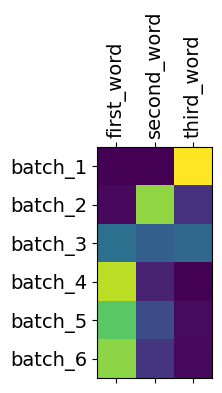

In [ ]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

if __name__ == '__main__':
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = BiLSTM_Attention()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad()
        output, attention = model(inputs)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()

#**Section 5.2**

**Explaination**

This code trains a simple LSTM-based model to predict the last character of a 4-letter word given the first 3 letters. It defines a TextLSTM class with an LSTM layer followed by a linear layer. The make_batch function prepares one-hot encoded input sequences and their corresponding target characters. The model is trained using cross-entropy loss over 1000 epochs. After training, it predicts the last character for each 3-letter input. The input characters are encoded using dictionaries, and predictions are decoded back to characters using number_dict. The model uses PyTorch with Adam optimizer and a hidden size of 128.

In [ ]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

def make_batch():
    input_batch, target_batch = [], []

    for seq in seq_data:
        input = [word_dict[n] for n in seq[:-1]] # 'm', 'a' , 'k' is input
        target = word_dict[seq[-1]] # 'e' is target
        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, X):
        input = X.transpose(0, 1)  # X : [n_step, batch_size, n_class]

        hidden_state = torch.zeros(1, len(X), n_hidden)  # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        cell_state = torch.zeros(1, len(X), n_hidden)     # [num_layers(=1) * num_directions(=1), batch_size, n_hidden]

        outputs, (_, _) = self.lstm(input, (hidden_state, cell_state))
        outputs = outputs[-1]  # [batch_size, n_hidden]
        model = self.W(outputs) + self.b  # model : [batch_size, n_class]
        return model

if __name__ == '__main__':
    n_step = 3 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    char_arr = [c for c in 'abcdefghijklmnopqrstuvwxyz']
    word_dict = {n: i for i, n in enumerate(char_arr)}
    number_dict = {i: w for i, w in enumerate(char_arr)}
    n_class = len(word_dict)  # number of class(=number of vocab)

    seq_data = ['make', 'need', 'coal', 'word', 'love', 'hate', 'live', 'home', 'hash', 'star']

    model = TextLSTM()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.FloatTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    # Training
    for epoch in range(1000):
        optimizer.zero_grad()

        output = model(input_batch)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 100 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    inputs = [sen[:3] for sen in seq_data]

    predict = model(input_batch).data.max(1, keepdim=True)[1]
    print(inputs, '->', [number_dict[n.item()] for n in predict.squeeze()])

Epoch: 0100 cost = 0.503017
Epoch: 0200 cost = 0.038914
Epoch: 0300 cost = 0.010570
Epoch: 0400 cost = 0.004768
Epoch: 0500 cost = 0.002761
Epoch: 0600 cost = 0.001819
Epoch: 0700 cost = 0.001297
Epoch: 0800 cost = 0.000974
Epoch: 0900 cost = 0.000759
Epoch: 1000 cost = 0.000609
['mak', 'nee', 'coa', 'wor', 'lov', 'hat', 'liv', 'hom', 'has', 'sta'] -> ['e', 'd', 'l', 'd', 'e', 'e', 'e', 'e', 'h', 'r']


# **Section 5.3**

**Explaination**

This code builds a BiLSTM model with attention for binary text classification (good vs bad sentences). It embeds input words and passes them through a bidirectional LSTM. An attention mechanism computes weights over time steps to focus on important words. The context vector from attention is passed to a linear layer for classification. The model is trained on 6 short sentences with binary labels using cross-entropy loss. After training, it predicts sentiment for a test sentence. Finally, attention weights are visualized to show which words the model focused on for each sentence.

Epoch: 1000 cost = 0.004566
Epoch: 2000 cost = 0.001070
Epoch: 3000 cost = 0.000411
Epoch: 4000 cost = 0.000191
Epoch: 5000 cost = 0.000099
sorry hate you is Bad Mean...


<ipython-input-22-169a4a541533>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
<ipython-input-22-169a4a541533>:90: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})


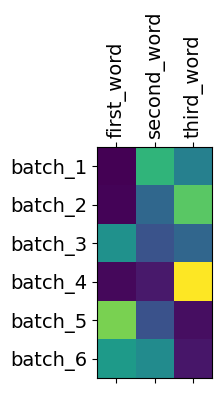

In [ ]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
# Reference : https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/LSTM_Attn.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)

    # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = self.embedding(X) # input : [batch_size, len_seq, embedding_dim]
        input = input.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]

        hidden_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        cell_state = torch.zeros(1*2, len(X), n_hidden) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.out(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

if __name__ == '__main__':
    embedding_dim = 2 # embedding size
    n_hidden = 5  # number of hidden units in one cell
    num_classes = 2  # 0 or 1

    # 3 words sentences (=sequence_length is 3)
    sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
    labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    vocab_size = len(word_dict)

    model = BiLSTM_Attention()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
    targets = torch.LongTensor([out for out in labels])  # To using Torch Softmax Loss function

    # Training
    for epoch in range(5000):
        optimizer.zero_grad()
        output, attention = model(inputs)
        loss = criterion(output, targets)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_text = 'sorry hate you'
    tests = [np.asarray([word_dict[n] for n in test_text.split()])]
    test_batch = torch.LongTensor(tests)

    # Predict
    predict, _ = model(test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    if predict[0][0] == 0:
        print(test_text,"is Bad Mean...")
    else:
        print(test_text,"is Good Mean!!")

    fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
    plt.show()

# **Section 6.1**

**Explaination**

This code implements a simplified Transformer model for translating the German sentence "ich mochte ein bier" to English using PyTorch. It defines the full Transformer architecture, including multi-head attention, positional encoding, and feed-forward layers. Input and output sequences are tokenized with special symbols (S, E, P) for start, end, and padding. The model is trained using cross-entropy loss for 20 epochs on one example. A greedy decoder generates the English translation word-by-word during inference. Finally, attention weights from encoder, decoder, and encoder-decoder layers are visualized to understand which words the model focuses on.

Epoch: 0001 cost = 2.242088
Epoch: 0002 cost = 3.164317
Epoch: 0003 cost = 2.702710
Epoch: 0004 cost = 4.025821
Epoch: 0005 cost = 2.687594
Epoch: 0006 cost = 4.632997
Epoch: 0007 cost = 4.848940
Epoch: 0008 cost = 3.253260
Epoch: 0009 cost = 4.974980
Epoch: 0010 cost = 2.886365
Epoch: 0011 cost = 2.106899
Epoch: 0012 cost = 1.683615
Epoch: 0013 cost = 1.820564
Epoch: 0014 cost = 1.942357
Epoch: 0015 cost = 1.932195
Epoch: 0016 cost = 1.842833
Epoch: 0017 cost = 1.737299
Epoch: 0018 cost = 1.655485
Epoch: 0019 cost = 1.621572
Epoch: 0020 cost = 1.634485
ich mochte ein bier P -> ['E', 'E', 'E', 'E', 'E']
first head of last state enc_self_attns


<ipython-input-23-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-23-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


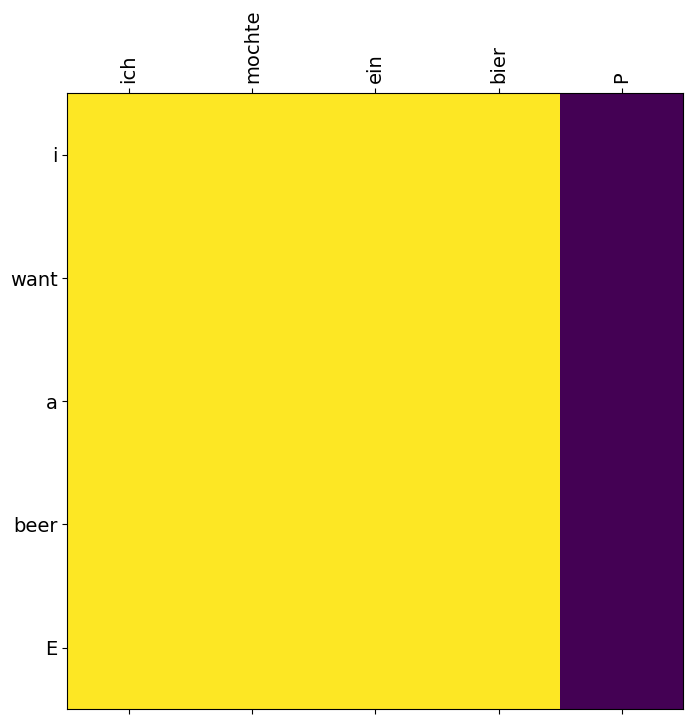

first head of last state dec_self_attns


<ipython-input-23-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-23-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


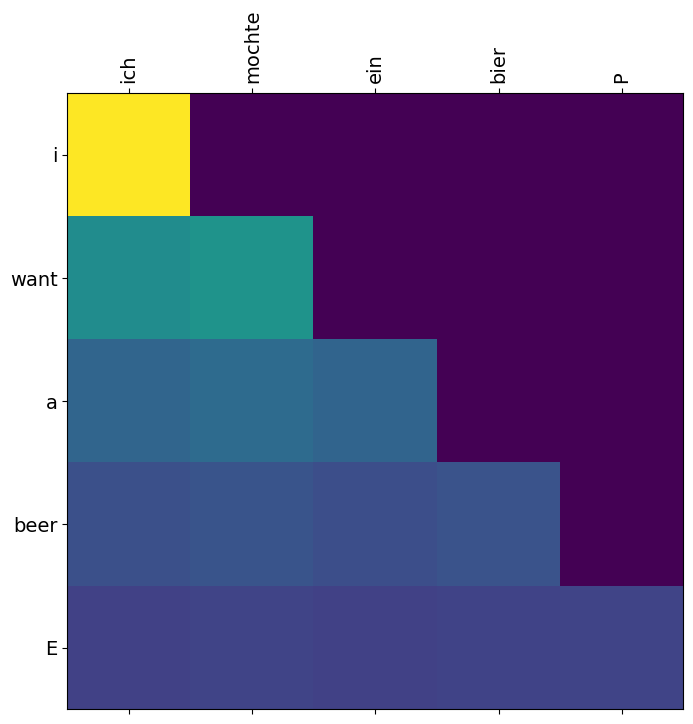

first head of last state dec_enc_attns


<ipython-input-23-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-23-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


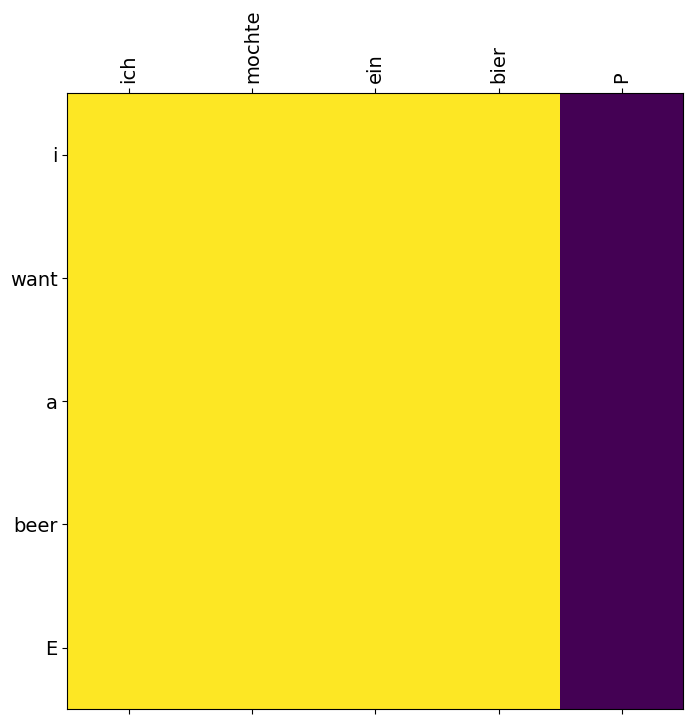

In [ ]:
# code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
# Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
#           https://github.com/JayParks/transformer
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    # print(seq_q)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 5).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, 5):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

if __name__ == '__main__':
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
    # Transformer Parameters
    # Padding Should be Zero index
    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    tgt_vocab_size = len(tgt_vocab)

    src_len = 5 # length of source
    tgt_len = 5 # length of target

    d_model = 512  # Embedding Size
    d_ff = 2048  # FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_layers = 6  # number of Encoder of Decoder Layer
    n_heads = 8  # number of heads in Multi-Head Attention

    model = Transformer()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    enc_inputs, dec_inputs, target_batch = make_batch()

    for epoch in range(20):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

    # Test
    greedy_dec_input = greedy_decoder(model, enc_inputs, start_symbol=tgt_vocab["S"])
    predict, _, _, _ = model(enc_inputs, greedy_dec_input)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    print('first head of last state enc_self_attns')
    showgraph(enc_self_attns)

    print('first head of last state dec_self_attns')
    showgraph(dec_self_attns)

    print('first head of last state dec_enc_attns')
    showgraph(dec_enc_attns)

# **Section 6.2**

**Explaination**

This code implements a Transformer model for translating simple German to English sentences using PyTorch. It builds encoder and decoder layers with multi-head attention, feed-forward networks, and sinusoidal positional encoding. make_batch() prepares training input/output from predefined sentences. The training loop optimizes cross-entropy loss between model predictions and targets. A greedy_decoder() is used to generate predictions step-by-step during inference. The model uses S (start), E (end), and P (padding) tokens for processing sequences. Attention weights are visualized using matplotlib to show how the model focuses on source words during decoding.

Epoch: 0001 cost = 2.066131
Epoch: 0002 cost = 3.756060
Epoch: 0003 cost = 3.087695
Epoch: 0004 cost = 5.040509
Epoch: 0005 cost = 5.045118
Epoch: 0006 cost = 4.480014
Epoch: 0007 cost = 7.202988
Epoch: 0008 cost = 5.487180
Epoch: 0009 cost = 4.416338
Epoch: 0010 cost = 3.156856
Epoch: 0011 cost = 2.200740
Epoch: 0012 cost = 1.758804
Epoch: 0013 cost = 1.942437
Epoch: 0014 cost = 2.128286
Epoch: 0015 cost = 2.232721
Epoch: 0016 cost = 2.210857
Epoch: 0017 cost = 2.078488
Epoch: 0018 cost = 1.912695
Epoch: 0019 cost = 1.770401
Epoch: 0020 cost = 1.674027
ich mochte ein bier P -> ['beer', 'beer', 'beer', 'beer', 'beer']
first head of last state enc_self_attns


<ipython-input-24-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-24-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


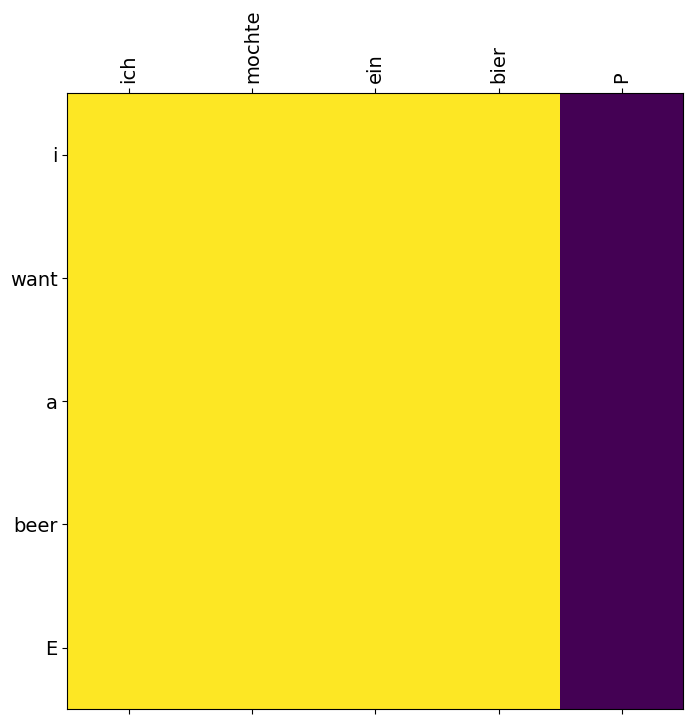

first head of last state dec_self_attns


<ipython-input-24-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-24-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


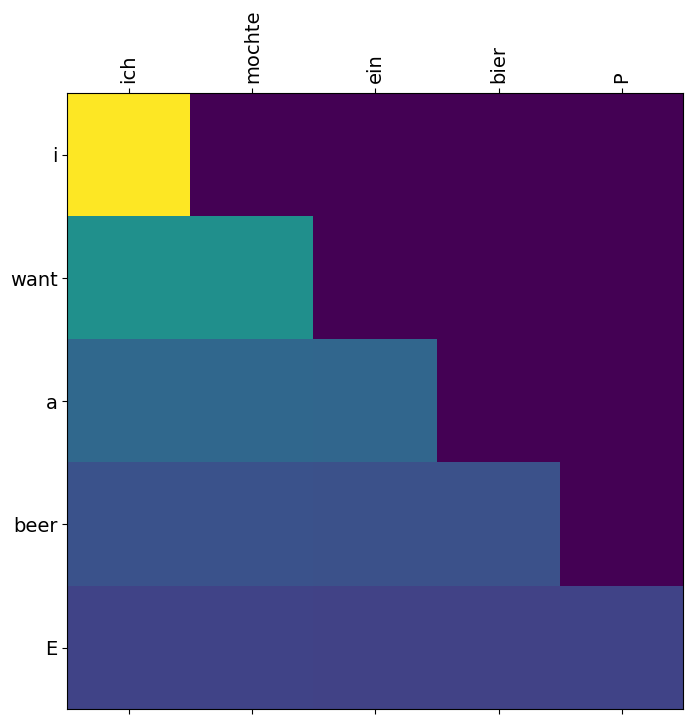

first head of last state dec_enc_attns


<ipython-input-24-c20c69d64cd0>:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
<ipython-input-24-c20c69d64cd0>:197: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


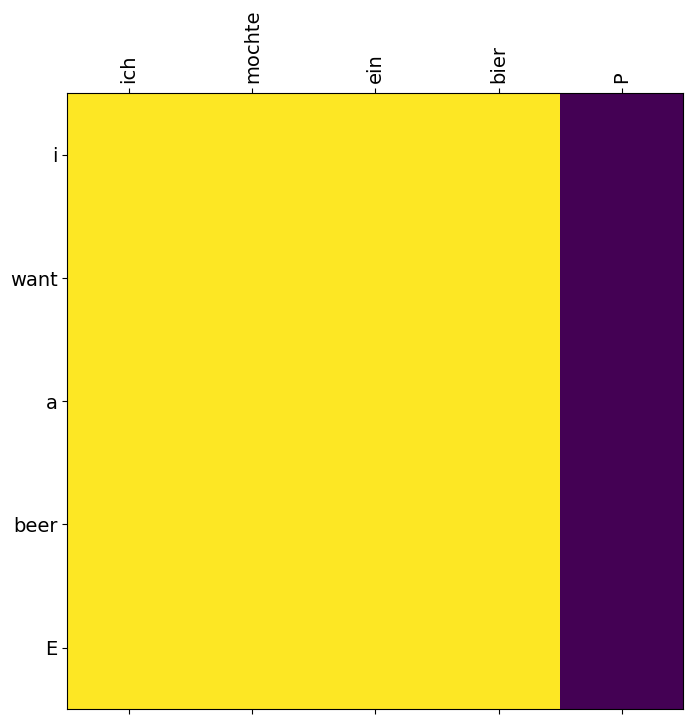

In [ ]:
# code by Tae Hwan Jung(Jeff Jung) @graykode, Derek Miller @dmmiller612
# Reference : https://github.com/jadore801120/attention-is-all-you-need-pytorch
#           https://github.com/JayParks/transformer
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

def get_attn_pad_mask(seq_q, seq_k):
    # print(seq_q)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_outputs, enc_self_attns = model.encoder(enc_input)
    dec_input = torch.zeros(1, 5).type_as(enc_input.data)
    next_symbol = start_symbol
    for i in range(0, 5):
        dec_input[0][i] = next_symbol
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[i]
        next_symbol = next_word.item()
    return dec_input

def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

if __name__ == '__main__':
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']
    # Transformer Parameters
    # Padding Should be Zero index
    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    tgt_vocab_size = len(tgt_vocab)

    src_len = 5 # length of source
    tgt_len = 5 # length of target

    d_model = 512  # Embedding Size
    d_ff = 2048  # FeedForward dimension
    d_k = d_v = 64  # dimension of K(=Q), V
    n_layers = 6  # number of Encoder of Decoder Layer
    n_heads = 8  # number of heads in Multi-Head Attention

    model = Transformer()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    enc_inputs, dec_inputs, target_batch = make_batch()

    for epoch in range(20):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

    # Test
    greedy_dec_input = greedy_decoder(model, enc_inputs, start_symbol=tgt_vocab["S"])
    predict, _, _, _ = model(enc_inputs, greedy_dec_input)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    print('first head of last state enc_self_attns')
    showgraph(enc_self_attns)

    print('first head of last state dec_self_attns')
    showgraph(dec_self_attns)

    print('first head of last state dec_enc_attns')
    showgraph(dec_enc_attns)